In [2]:
import numpy as np
import mitsuba as mi
import matplotlib as mpl
import matplotlib.pyplot as plt

# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

from sionna.rt import load_scene, Camera, Transmitter, Receiver, PlanarArray,\
                      PathSolver, RadioMapSolver, load_mesh, watt_to_dbm, transform_mesh,\
                      cpx_abs_square

no_preview = True # Toggle to False to use the preview widget
                  # instead of rendering for scene visualization

In [3]:
scene = load_scene() # Load empty scene

# Configure antenna arrays for all transmitters and receivers
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             pattern="iso",
                             polarization="V")
scene.rx_array = scene.tx_array

# Define and add a first transmitter to the scene
tx0 = Transmitter(name='tx0',
                  position=[150, -100, 20],
                  orientation=[np.pi*5/6, 0, 0],
                  power_dbm=44)
scene.add(tx0)

# Compute radio map
rm_solver = RadioMapSolver()
rm = rm_solver(scene,
               max_depth=5,           # Maximum number of ray scene interactions
               samples_per_tx=10**7 , # If you increase: less noise, but more memory required
               cell_size=(5, 5),      # Resolution of the radio map
               center=[0, 0, 0],      # Center of the radio map
               size=[400, 400],       # Total size of the radio map
               orientation=[0, 0, 0]) # Orientation of the radio map, e.g., could be also vertical

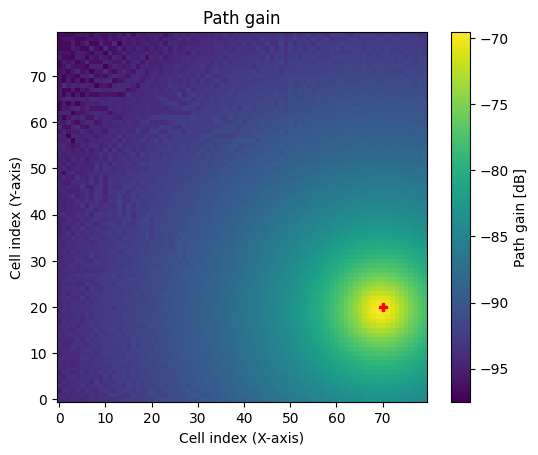

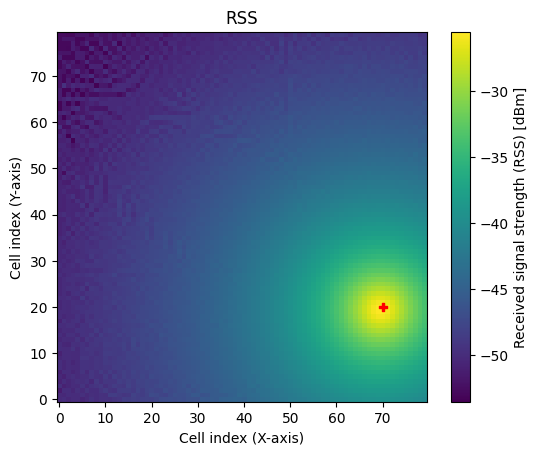

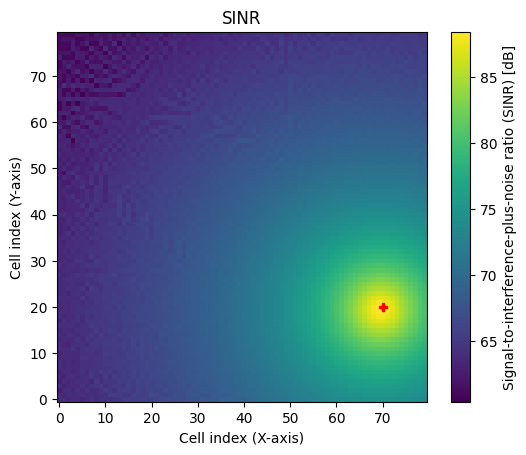

In [4]:
# Visualize path gain
rm.show(metric="path_gain");

# Visualize received signal strength (RSS)
rm.show(metric="rss");

# Visulaize SINR
rm.show(metric="sinr");

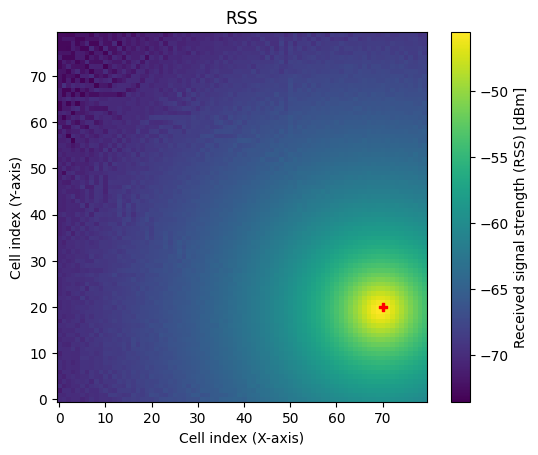

In [5]:
tx0.power_dbm = 24
rm = rm_solver(scene,
               max_depth=5,
               samples_per_tx=10**7,
               cell_size=(5, 5),
               center=[0, 0, 0],
               size=[400, 400],
               orientation=[0, 0, 0])
rm.show(metric="rss");

In [6]:
print(f"Bandwidth: ", scene.bandwidth.numpy(), "[Hz]")
print(f"Temperature: ", scene.temperature.numpy(), "[K]")
print(f"Thermal noise power: ", watt_to_dbm(scene.thermal_noise_power).numpy(), "[dBm]")

Bandwidth:  [1000000.] [Hz]
Temperature:  [293.] [K]
Thermal noise power:  [-113.93048] [dBm]


In [7]:
# Metrics have the shape
# [num_tx, num_cells_y, num_cells_x]

print(f'{rm.path_gain.shape=}') # Path gain
print(f'{rm.rss.shape=}') # RSS
print(f'{rm.sinr.shape=}') # SINR

# The location of all cell centers in the global coordinate system of the scene
# can be accessed via:
# [num_cells_y, num_cells_x, 3]
print(f'{rm.cell_centers.shape=}')

rm.path_gain.shape=(1, 80, 80)
rm.rss.shape=(1, 80, 80)
rm.sinr.shape=(1, 80, 80)
rm.cell_centers.shape=(80, 80, 3)


In [8]:
# Remove transmitters here so that the cell can be executed multiple times
scene.remove("tx1")
scene.remove("tx2")

tx1 = Transmitter(name='tx1',
                  position=[-150, -100, 20],
                  orientation=[np.pi/6, 0, 0],
                  power_dbm=21)
scene.add(tx1)

tx2 = Transmitter(name='tx2',
                  position=np.array([0, 150 * np.tan(np.pi/3) - 100, 20]),
                  orientation=[-np.pi/2, 0, 0],
                  power_dbm=27)
scene.add(tx2)

rm = rm_solver(scene,
               max_depth=5,
               samples_per_tx=10**7,
               cell_size=(5, 5),
               center=[0, 0, 0],
               size=[400, 400],
               orientation=[0, 0, 0])

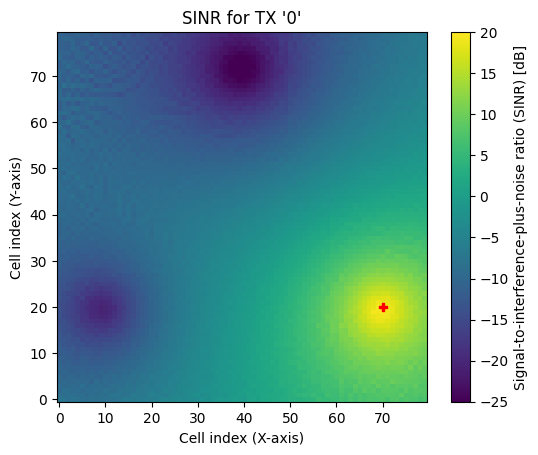

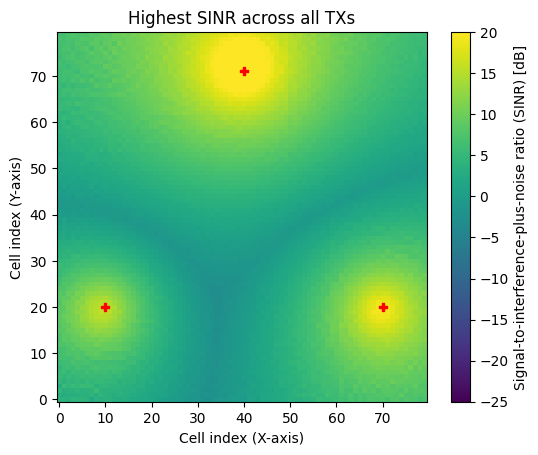

In [9]:
# Show SINR for tx0
rm.show(metric="sinr", tx=0, vmin=-25, vmax=20);

# Show maximum SINR across all transmitters
rm.show(metric="sinr", tx=None, vmin=-25, vmax=20);

# Experiment: Change the metric to "path_gain" or "rss"
#             and play around with the parameters vmin/vmax
#             that determine the range of the colo

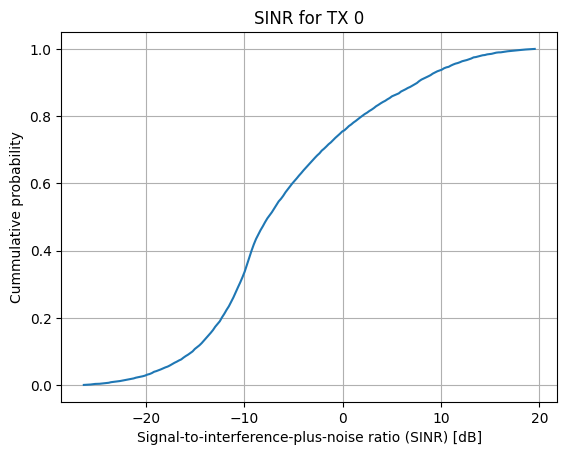

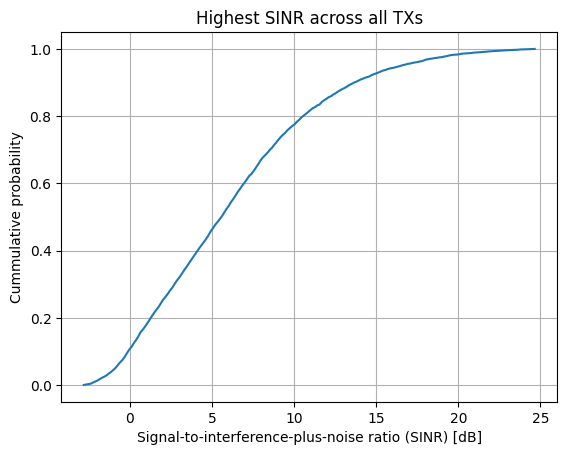

In [10]:
# CDF of the SINR for transmitter 0
rm.cdf(metric="sinr", tx=0);

# CDF of the SINR if always the transmitter providing the best SINR is selected
rm.cdf(metric="sinr");

rm.tx_association("sinr").shape=(80, 80)


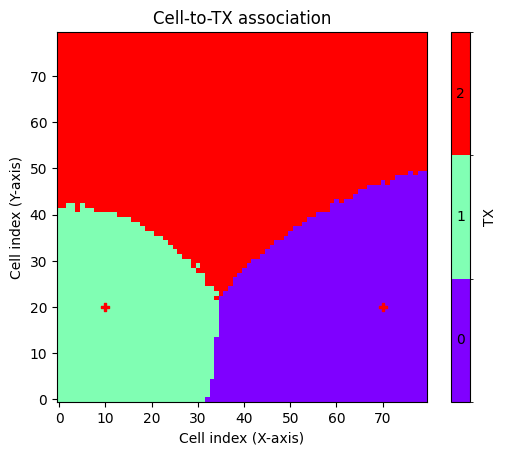

In [11]:
# Get for every cell the tx index providing the strongest value
# of the chosen metric
# [num_cells_y, num_cells_x]
print(f'{rm.tx_association("sinr").shape=}')

rm.show_association("sinr");

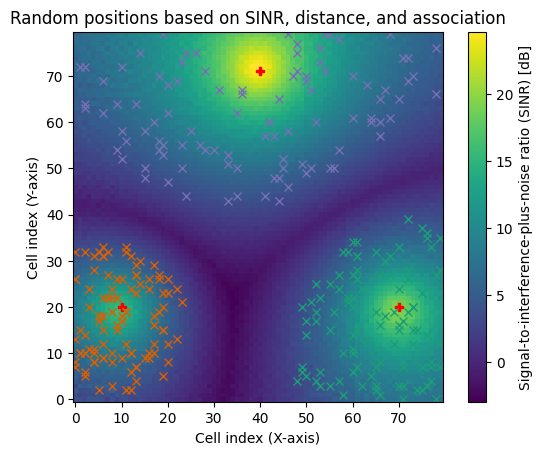

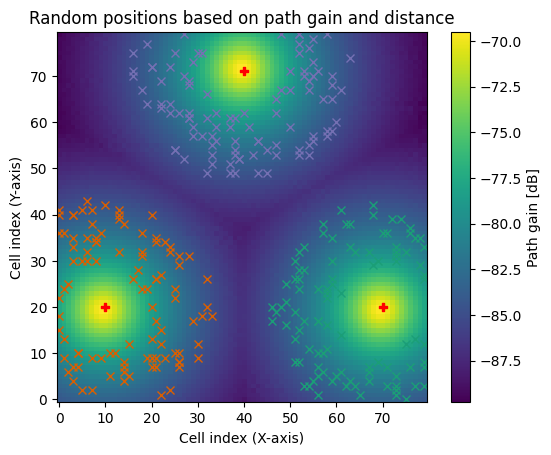

In [12]:
pos, cell_ids = rm.sample_positions(
          num_pos=100,         # Number of random positions per receiver
          metric="sinr",       # Metric on which constraints and TX association will be applied
          min_val_db=3,        # Mininum value for the chosen metric
          max_val_db=20,       # Maximum value for the chosen metric
          min_dist=10,         # Minimum distance from transmitter
          max_dist=200,        # Maximum distance from transmitter
          tx_association=True, # If True, only positions associated with a transmitter are chosen,
                               # i.e., positions where the chosen metric is the highest among all TXs
          center_pos=False)    # If True, random positions correspond to cell centers,
                               # otherwise a random offset within each cell is applied

fig = rm.show(metric="sinr");
plt.title("Random positions based on SINR, distance, and association")
# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])


pos, cell_ids = rm.sample_positions(
          num_pos=100,          # Number of random positions per receiver
          metric="path_gain",   # Metric on which constraints will be applied
          min_val_db=-85,        # Mininum value for the chosen metric
          min_dist=50,          # Minimum distance from transmitter
          max_dist=200,         # Maximum distance from transmitter
          tx_association=False, # If False, then a user located in a sampled position
                                # for a specific TX may perceive a higher metric from another TX!
          center_pos=False)     # If True, random positions correspond to cell centers,
                                # otherwise a random offset within each cell is applied

fig = rm.show(metric="path_gain");
plt.title("Random positions based on path gain and distance")
# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])

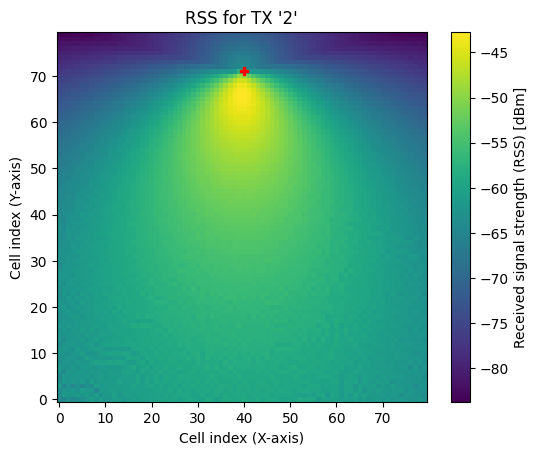

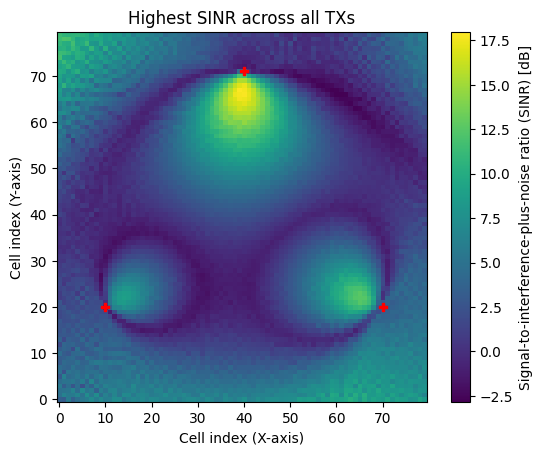

In [13]:
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",   # Change to "iso" and compare the results
                             polarization="V")

rm = rm_solver(scene,
               max_depth=5,
               samples_per_tx=10**7,
               cell_size=(5, 5),
               center=[0, 0, 0],
               size=[400, 400],
               orientation=[0, 0, 0])

rm.show(metric="rss", tx=2);

rm.show(metric="sinr");

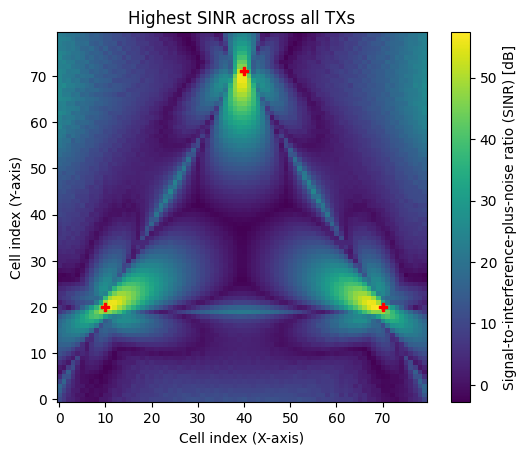

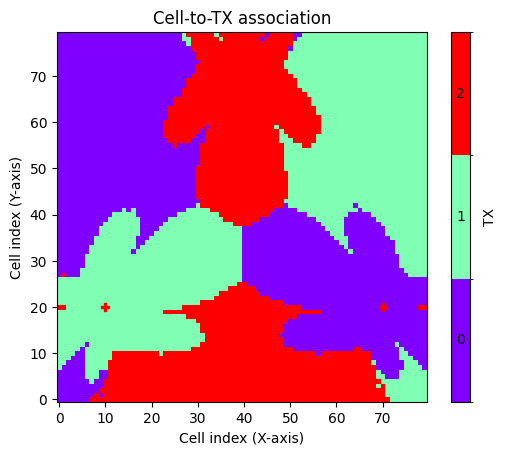

In [14]:
# Number of elements of the rectangular antenna array
num_rows = 2
num_cols = 4

# Configure all transmitters to have equal power
tx0.power_dbm = 23
tx1.power_dbm = 23
tx2.power_dbm = 23

# Configure tr38901 uniform rectangular antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=num_rows,
                             num_cols=num_cols,
                             pattern="tr38901",
                             polarization="V")

# Create a common precoding vector used by all transmitters
# It is also possible to assign individual
precoding_vec = [1, -1]*4 / np.sqrt(8)

# Convert to tuple of Mitsuba vectors
precoding_vec = (mi.TensorXf(precoding_vec.real),
                 mi.TensorXf(precoding_vec.imag))

# Compute the radio map
rm = rm_solver(scene,
               max_depth=5,
               samples_per_tx=10**7,
               precoding_vec=precoding_vec,
               cell_size=(5, 5),
               center=[0, 0, 0],
               size=[400, 400],
               orientation=[0, 0, 0])

rm.show(metric="sinr");
rm.show_association(metric="sinr");

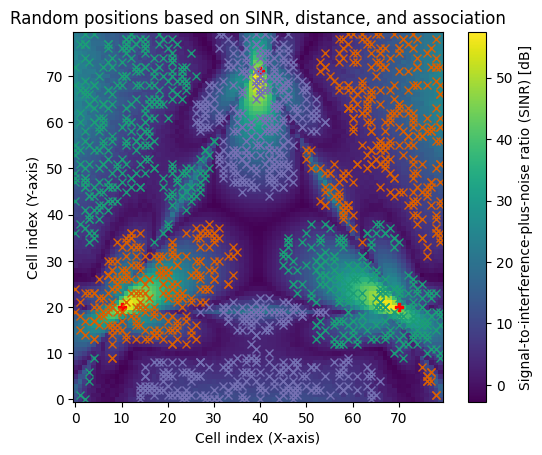

In [15]:
pos, cell_ids = rm.sample_positions(
          num_pos=500,
          metric="sinr",
          min_val_db=3,
          min_dist=10,
          tx_association=True)

fig = rm.show(metric="sinr");

# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])
plt.title("Random positions based on SINR, distance, and association");

In [17]:
def config_scene(num_rows, num_cols):
    """Load and configure a scene"""
    scene = load_scene(sionna.rt.scene.etoile)
    scene.bandwidth=100e6

    # Configure antenna arrays for all transmitters and receivers
    scene.tx_array = PlanarArray(num_rows=num_rows,
                                 num_cols=num_cols,
                                 pattern="tr38901",
                                 polarization="V")

    scene.rx_array = PlanarArray(num_rows=1,
                                 num_cols=1,
                                 pattern="iso",
                                 polarization="V")

    # Place transmitters
    positions = np.array(
                 [[-150.3, 21.63, 42.5],
                  [-125.1, 9.58, 42.5],
                  [-104.5, 54.94, 42.5],
                  [-128.6, 66.73, 42.5],
                  [172.1, 103.7, 24],
                  [232.8, -95.5, 17],
                  [80.1, 193.8, 21]
                 ])
    look_ats = np.array(
                [[-216, -21,0],
                 [-90, -80, 0],
                 [-16.5, 75.8, 0],
                 [-164, 153.7, 0],
                 [247, 92, 0],
                 [211, -180, 0],
                 [126.3, 194.7, 0]
                ])
    power_dbms = [23, 23, 23, 23, 23, 23, 23]

    for i, position in enumerate(positions):
        scene.add(Transmitter(name=f'tx{i}',
                              position=position,
                              look_at=look_ats[i],
                              power_dbm=power_dbms[i]))

    return scene

In [18]:
# Load and configure scene
num_rows=8
num_cols=2
scene_etoile = config_scene(num_rows, num_cols)

# Compute the SINR map
rm_etoile = rm_solver(scene_etoile,
                      max_depth=5,
                      samples_per_tx=10**7,
                      cell_size=(1, 1))

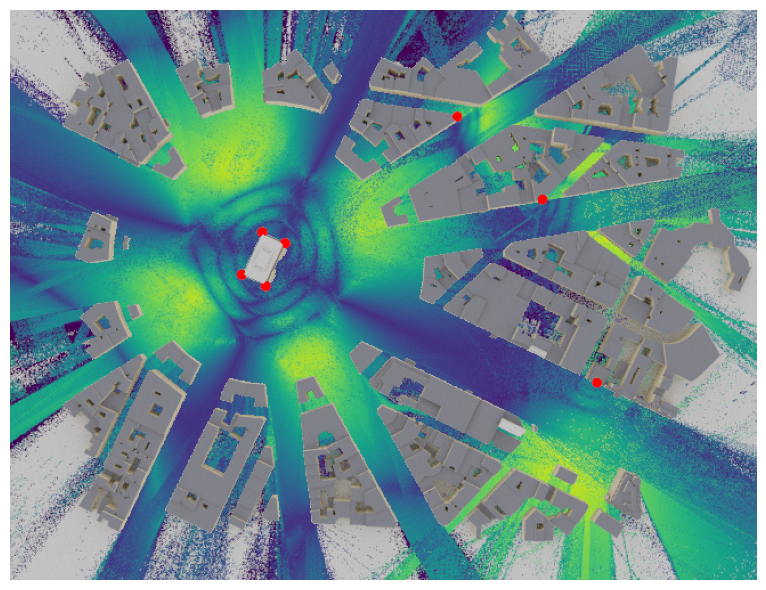

In [19]:
if no_preview:
    # Render an image
    cam = Camera(position=[0,0,1000],
                     orientation=np.array([0,np.pi/2,-np.pi/2]))
    scene_etoile.render(camera=cam,
                        radio_map=rm_etoile,
                        rm_metric="sinr",
                        rm_vmin=-10,
                        rm_vmax=60);
else:
    # Show preview
    scene_etoile.preview(radio_map=rm_etoile,
                         rm_metric="sinr",
                         rm_vmin=-10,
                         rm_vmax=60)

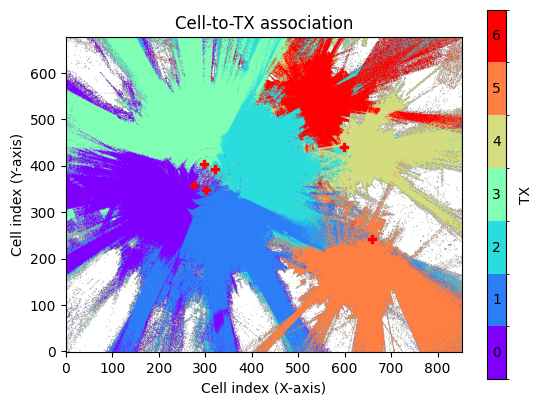

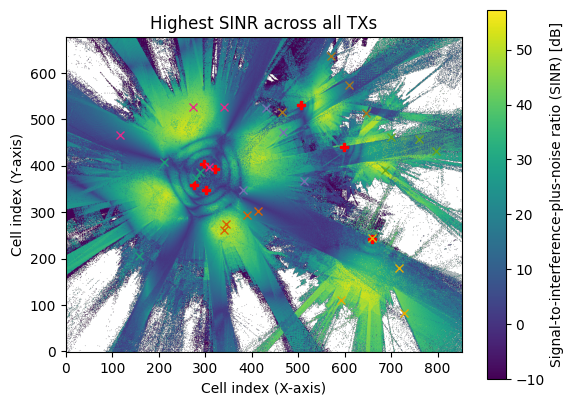

In [20]:
rm_etoile.show_association("sinr");

pos, cell_ids = rm_etoile.sample_positions(
          num_pos=4,
          metric="sinr",
          min_val_db=3,
          min_dist=10,
          max_dist=200,
          tx_association=True)

fig = rm_etoile.show(metric="sinr", vmin=-10);

# Visualize sampled positions
for tx, ids in enumerate(cell_ids.numpy()):
    fig.axes[0].plot(ids[:,1], ids[:,0],
                     marker='x',
                     linestyle='',
                     color=mpl.colormaps['Dark2'].colors[tx])

In [21]:
[scene_etoile.remove(rx.name) for rx in scene_etoile.receivers.values()]
for i in range(rm_etoile.num_tx):
    for j in range(pos.shape[1]):
        scene_etoile.add(Receiver(name=f"rx-{i}-{j}",
                                  position=pos[i,j].numpy()))

p_solver = PathSolver()
paths = p_solver(scene_etoile, max_depth=5)

# Channel impulse response
a, tau = paths.cir()

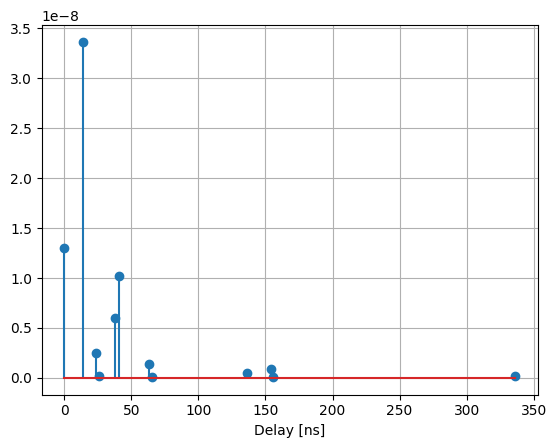

In [22]:
# Transmitter and receiver indices to plot the channel impulse response
tx_index = 0
rx_index = 0

# Compute the squared magnitude of the path coefficients
a_abs_square = cpx_abs_square(a)
# # Sum over the transmit antennas
a_abs_square = np.sum(a_abs_square, axis=3)

# Get the selected path coefficients and delays in ns
a_abs_square = np.squeeze(a_abs_square)[rx_index, tx_index]
tau_ns = np.squeeze(tau)[rx_index, tx_index]*1e9

# Only keep the valid paths
valid = paths.valid.numpy()
valid = valid[rx_index, tx_index]
a_abs_square = a_abs_square[valid]
tau_ns = tau_ns[valid]

# Plot the channel impulse response
plt.figure()
plt.stem(tau_ns, a_abs_square)
plt.xlabel("Delay [ns]")
plt.grid(True)

In [23]:
# Empty scene
scene = load_scene()

# Use a single antenna with directive pattern
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             pattern="tr38901",
                             polarization="V")

# Add a transmitter
scene.add(Transmitter(name="tx",
                      position=[0, 0, 0],
                      orientation=[0, 0, 0]))

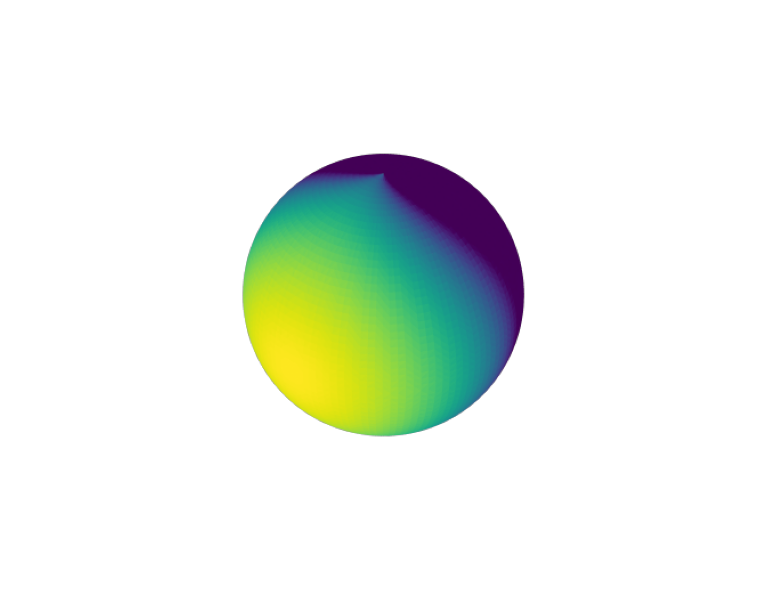

In [24]:
# Load the mesh of a sphere
sphere = load_mesh(sionna.rt.scene.sphere)

# Instantiate the radio map solver
rm_solver = RadioMapSolver()

# Compute radio map using the sphere as the measurement surface
rm = rm_solver(scene,
               measurement_surface=sphere,
               samples_per_tx=10**7)

if no_preview:
    cam = Camera(position=[4, 3, 4])
    cam.look_at(np.array([0, 0, 0]))
    scene.render(camera=cam,
                 radio_map=rm);
else:
    scene.preview(radio_map=rm);

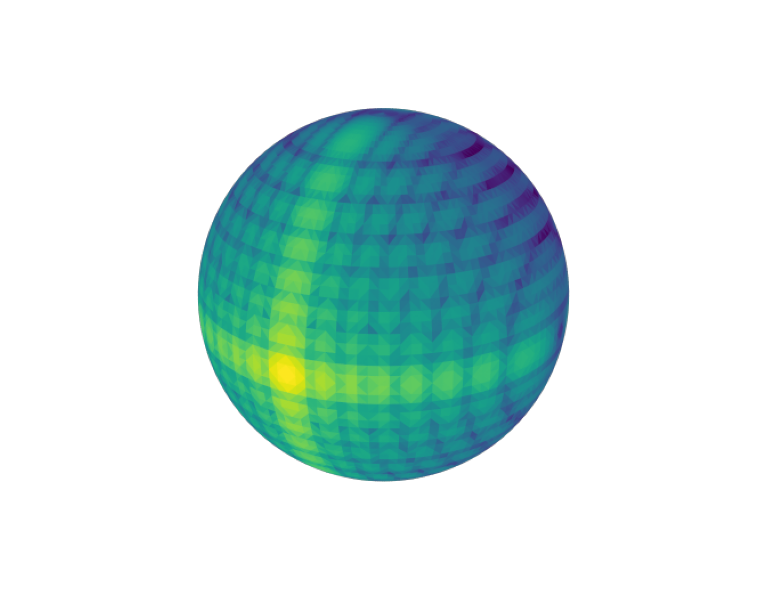

In [25]:
# Use an 16x16 antenna array with directive pattern
scene.tx_array = PlanarArray(num_rows=16,
                             num_cols=16,
                             pattern="tr38901",
                             polarization="V")

# Compute radio map using the sphere as the measurement surface
rm = rm_solver(scene,
               measurement_surface=sphere,
               samples_per_tx=10**7)

if no_preview:
    cam = Camera(position=[4, 2, 2])
    cam.look_at(np.array([0, 0, 0]))
    scene.render(camera=cam,
                 radio_map=rm);
else:
    scene.preview(radio_map=rm);

In [26]:
# Load a scene with a complex terrain
scene = load_scene(sionna.rt.scene.san_francisco)

# Use a single antenna with isotropic pattern
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             pattern="iso",
                             polarization="V")

# Add a transmitter+
scene.add(Transmitter(name="tx",
                      position=[468, 106, 70],
                      orientation=[0, 0, 0],
                      display_radius=5))

In [27]:
# Clone the terrain mesh
mesurement_surface = scene.objects["Terrain"].clone(as_mesh=True)
# Shift the terrain upwards by 1.5 meters
transform_mesh(mesurement_surface, translation=np.array([0, 0, 1.5]))

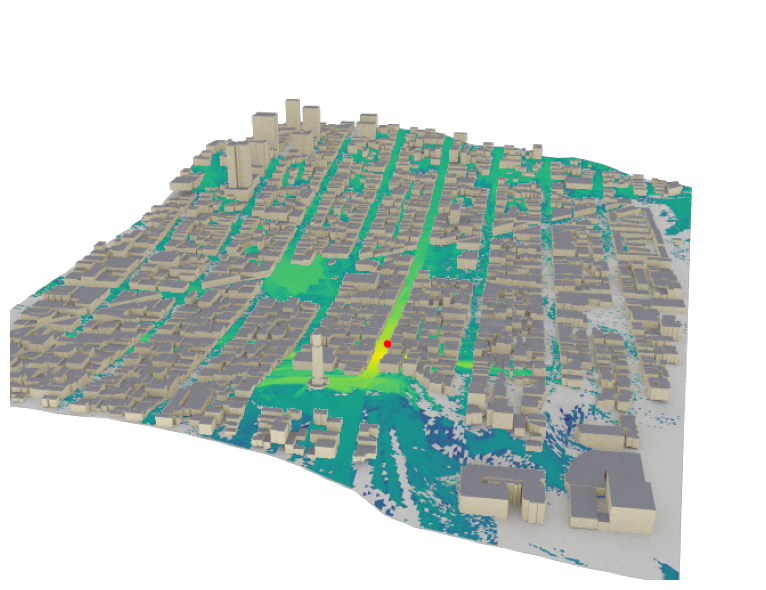

In [28]:
# Compute radio map using the measurement surface
rm = rm_solver(scene,
               measurement_surface=mesurement_surface,
               samples_per_tx=10**8,
               max_depth=5)

if no_preview:
    cam = Camera(position=[1400, 400, 575])
    cam.look_at(np.array([310, 50, 60]))
    scene.render(camera=cam,
                 radio_map=rm);
else:
    scene.preview(radio_map=rm, rm_vmin=-100);